 # 실험 내용

실험 목적

- CLIP 모델을 사용하여 이미지를 벡터화하고 벡터 DB에 저장한 후, 유사 이미지 검색 시 'person' 클래스를 마스킹하는 것과 하지 않는 것의 성능 차이를 평가

 사용 데이터
- CLIP 테스트에 사용한 egypt landmark 이미지 데이터셋을 기반으로 테스트

 실험 단계

 1. 데이터 전처리 및 벡터 DB 구축
 
- 단계 1A: 원본 이미지를 사용하여 벡터 DB를 구축
    - 각 이미지를 CLIP 모델을 사용하여 벡터화
    - 벡터화된 이미지를 벡터 DB에 저장

- 단계 1B: 'person' 클래스가 마스킹된 이미지로 벡터 DB를 구축
    - Mask R-CNN을 사용하여 각 이미지에서 'person' 클래스를 식별하고 마스킹 처리
    - 마스킹 처리된 이미지를 CLIP 모델을 사용하여 벡터화
    - 벡터화된 이미지를 별도의 벡터 DB에 저장
    
   
 2. 유사 이미지 검색 실험
- 각 DB에 대해 유사 이미지 검색 실험 4가지를 수행
    - case 1. `마스킹하지 않은 벡터DB` 내에서 `마스킹하지 않은 이미지 검색'
    - case 2. `마스킹하지 않은 벡터DB` 내에서 `마스킹한 이미지 검색'
    - case 3. `마스킹한 벡터DB` 내에서 `마스킹하지 않은 이미지 검색'
    - case 4. `마스킹한 벡터DB` 내에서 `마스킹한 이미지 검색'


| 케이스 | 벡터 DB의 마스킹 처리 | 검색 대상 이미지의 마스킹 처리 | 설명                                                         |
|--------|-----------------------|--------------------------------|--------------------------------------------------------------|
| Case 1 | 마스킹 처리 안 함      | 마스킹 처리 안 함              | 마스킹 처리되지 않은 DB에서 마스킹 처리되지 않은 이미지 검색 |
| Case 2 | 마스킹 처리 안 함      | 마스킹 처리 함                 | 마스킹 처리되지 않은 DB에서 마스킹 처리된 이미지 검색        |
| Case 3 | 마스킹 처리 함         | 마스킹 처리 안 함              | 마스킹 처리된 DB에서 마스킹 처리되지 않은 이미지 검색        |
| Case 4 | 마스킹 처리 함         | 마스킹 처리 함                 | 마스킹 처리된 DB에서 마스킹 처리된 이미지 검색               |


- 실험방식
    - 기준 이미지를 선정하고, 이 이미지를 벡터화하여 검색 쿼리로 사용
    - 쿼리 이미지에 대해 각 DB에서 유사 이미지를 검색
    - 검색 결과의 정확성과 유사도 및 속도를 평가


- 실험 결과의 대조군은 `case1과 case3`이 A그룹이고, `case2와 case4`가 B그룹으로 설정
    - 그룹 선정 이유는 각 쌍이 유사한 조건 하에서의 성능 차이를 비교하기에 유용하기 때문
        - Case 1과 Case 3은 둘 다 마스킹하지 않은 이미지 검색에 초점을 맞추고 있음
        - Case 2와 Case 4는 마스킹한 이미지 검색에 집중하고 있음
    


3. 성능 비교 및 분석
- 유사도 분석 : 마스킹 처리된 이미지와 처리되지 않은 이미지를 사용한 검색 결과의 유사도 점수를 비교
    - 총 5개의 유사이미지를 찾도록하며, 해당 이미들의 유사도값 평균을 정확도 지표로 활용
    - 평균값을 사용하는 이유는 각 case마다 유사도가 높은 top5가 모두 다르기 때문
    - 이러한 점을 고려해 정확성 분석을 보조 평가지표로 선정
- 정확성 분석: 마스킹 처리된 이미지와 처리되지 않은 이미지를 사용한 검색 결과의 정확성을 비교
    - 기준이미지로 사용하는 장소명을 label로 하고, 검색된 벡터DB속 이미지의 메타데이터와 비교해 올바르게 이미지를 찾았는지를 평가
    - 전체 5개중 정답을 맞춘 개수로 정확도를 측정
- 속도 분석: 검색 처리 시간을 비교하여 마스킹 처리의 영향을 평가
---

In [1]:
# 파이토치 및 토치비전 관련 라이브러리
import torch
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn

# 이미지 처리를 위한 PIL 라이브러리
from PIL import Image
from transformers import CLIPProcessor, CLIPModel  # CLIP 모델 관련 라이브러리

# 넘파이 및 랜덤 모듈
import numpy as np
import random

# 운영 체제 및 경로 검색 관련 모듈
import os
from glob import glob

# 진행 상황을 시각화하기 위한 tqdm 모듈
from tqdm import tqdm

# chromadb 및 모델성능평가 관련 모듈
import chromadb
import time
import pandas as pd

# 시각화 관련 모듈
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import plotly.graph_objects as go

import warnings

# 모든 경고를 무시합니다.
warnings.filterwarnings("ignore")

##  1. 데이터 전처리 및 벡터 DB 구축

### 마스킹 함수

In [2]:
def preprocess_and_mask_image(image_path, confidence_threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    input_tensor = transform(image).unsqueeze(0)
    
    mask_model = maskrcnn_resnet50_fpn(pretrained=True).eval()
    with torch.no_grad():
        prediction = mask_model(input_tensor)
    
    masks = prediction[0]['masks']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']
    np_image = np.array(image)
    
    for i in range(len(scores)):
        if scores[i] > confidence_threshold and labels[i].item() == 1:
            mask = masks[i, 0]
            np_image[mask > 0.5] = [0, 0, 0]
    
    return Image.fromarray(np_image)

### CLIP 기반 벡터라이저 생성

In [3]:
def vectorizor(image_path, mask_people=False, confidence_threshold=0.5):
    if mask_people:
        image = preprocess_and_mask_image(image_path, confidence_threshold)
    else:
        image = Image.open(image_path).convert("RGB")
    
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    
    inputs = processor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    
    vector = image_features.detach().cpu().numpy().squeeze()
    return vector

### 벡터DB 시각화 함수

In [4]:
def visualize_embeddings_with_plotly(embeddings_list, metadatas):
    embeddings_array = np.array(embeddings_list)
    labels = [metadata['label'] for metadata in metadatas]

    pca = PCA(n_components=3)
    embeddings_reduced = pca.fit_transform(embeddings_array)

    unique_labels = list(set(labels))
    color_values = np.linspace(0, 1, len(unique_labels))
    colors = ['rgba(' + ', '.join([f'{int(x*255)}' for x in plt.cm.rainbow(c)[:3]]) + ', 0.8)' for c in color_values]
    label_to_color = {label: color for label, color in zip(unique_labels, colors)}

    fig = go.Figure()

    for label in unique_labels:
        idx = [i for i, l in enumerate(labels) if l == label]
        fig.add_trace(go.Scatter3d(
            x=embeddings_reduced[idx, 0],
            y=embeddings_reduced[idx, 1],
            z=embeddings_reduced[idx, 2],
            mode='markers',
            marker=dict(size=5, color=label_to_color[label], opacity=0.8),
            name=label
        ))

    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), scene=dict(
        xaxis_title='PCA 1',
        yaxis_title='PCA 2',
        zaxis_title='PCA 3'
    ))
    
    fig.show()

### 데이터셋 벡터DB화

In [5]:
def images_to_vector_db(image_directory, db_path, collection_name, mask_people=False):
    # 데이터베이스 클라이언트 생성
    client = chromadb.PersistentClient(path=db_path)

    # 기존 컬렉션 이름 리스트 생성
    existing_collection_names = [col.name for col in client.list_collections()]

    # 요청한 컬렉션 이름이 이미 존재하는지 확인
    if collection_name in existing_collection_names:
        # 이미 존재하는 경우 해당 컬렉션을 가져옴
        collection = client.get_collection(collection_name)
        print("Found existing collection, using it.")
    else:
        # 존재하지 않는 경우 새로운 컬렉션 생성
        collection = client.create_collection(collection_name)
        print("Created new collection.")

    # 이미지 파일 경로 리스트 생성
    img_list = sorted(glob(os.path.join(image_directory, "*/*.jpg")))
    
    # Embedding, Metadata 및 ID를 저장할 리스트 초기화
    embeddings = []
    metadatas = []
    ids = []
    
    # 이미지 처리 및 Embedding 생성 반복
    for i, img_path in enumerate(tqdm(img_list, desc="Processing images")):
        # 이미지 파일의 레이블 및 파일 이름 추출
        label_name = os.path.basename(os.path.dirname(img_path))
        file_name = os.path.basename(img_path)
        
        # 이미지의 Embedding 생성
        embedding = vectorizor(img_path, mask_people=mask_people)
        
        # Embedding, Metadata 및 ID를 리스트에 추가
        embeddings.append(embedding)
        metadatas.append({
            "uri": img_path,
            "label": label_name,
            "file_name": file_name
        })
        
        # 이미지 인덱스를 ID로 사용
        ids.append(str(i))
    
    # Embedding을 리스트로 변환
    embeddings_list = [embedding.tolist() for embedding in embeddings]
    
    # 데이터베이스에 데이터 추가
    collection.add(
        embeddings=embeddings_list,
        metadatas=metadatas,
        ids=ids,
    )
    
    print("Data upload completed!")
    
    # 벡터DB 시각화
    visualize_embeddings_with_plotly(embeddings_list, metadatas)

#### 마스킹을 하지 않은 벡터DB생성

In [6]:
# 마스킹을 적용한 벡터 DB 생성
images_to_vector_db(image_directory='data/chroma_test',
                    db_path='./data/masked_chroma_db',
                    collection_name='masked_travel',
                    mask_people=True)

Created new collection.


Processing images: 100%|█████████████████████████████████████████████████████████████| 378/378 [20:15<00:00,  3.22s/it]


Data upload completed!


#### 마스킹을 적용한 벡터DB생성

In [7]:
# 마스킹을 적용하지 않은 벡터 DB 생성
images_to_vector_db(image_directory='data/chroma_test',
                    db_path='./data/unmasked_chroma_db',
                    collection_name='unmasked_travel',
                    mask_people=False)

Created new collection.


Processing images: 100%|█████████████████████████████████████████████████████████████| 378/378 [13:26<00:00,  2.13s/it]


Data upload completed!


##  2. 유사 이미지 검색 실험

### 이미지 검색 함수

In [8]:
def query(img_path, collection_nm, n_results=3, mask_people=False, true_label=None):
    # 컬렉션 불러오기
    collection = client.get_collection(collection_nm)
    
    start_time = time.time()  # 검색 시작 시간
    
    # 이미지 경로로부터 이미지를 로드하고 RGB로 변환하는데, mask_people이 True이면 사람 마스킹 처리를 적용
    test_img = Image.open(img_path).convert("RGB") if not mask_people else preprocess_and_mask_image(img_path)

    # 이미지를 벡터화합니다. 이때, mask_people 매개변수를 활용합니다.
    test_embedding = vectorizor(img_path, mask_people=mask_people)

    # numpy.array를 리스트로 변환합니다.
    test_embedding_list = test_embedding.tolist()

    # 임베딩을 사용하여 쿼리 결과를 얻습니다.
    query_result = collection.query(
        query_embeddings=[test_embedding_list],
        n_results=n_results,
    )
    
    end_time = time.time()  # 검색 종료 시간
    search_time = end_time - start_time  # 검색에 걸린 시간
    
    # 결과 이미지 시각화
    fig, axes = plt.subplots(1, n_results + 1, figsize=(20, 5))
    axes[0].imshow(test_img)
    axes[0].set_title(f"{true_label} Img")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]
        result_img = Image.open(metadata["uri"]).convert("RGB")
        # 'label' 대신 존재하는 키를 사용하여 제목 설정
        label = metadata.get('label', 'unknown')  # 'label' 키가 없는 경우 '알 수 없음'을 사용
        axes[i+1].imshow(result_img)
        axes[i+1].set_title(f"{label}\ndistance: {distance:.2f}")
        axes[i+1].axis("off")

    plt.show()

    # 유사도 계산 (여기서는 단순화를 위해 거리 값을 역수로 사용)
#     distances = query_result["distances"][0]
#     similarities = [1/d for d in distances]  # 거리의 역수를 유사도로 사용
    similarities = query_result["distances"][0]

    # 정답 맞춘 개수 계산
    correct_matches = sum(1 for metadata in query_result["metadatas"][0] if metadata.get('label') == true_label)
    
    # 정확도 계산 (맞춘 개수 / 총 결과 개수)
    accuracy = correct_matches / n_results if n_results else 0

    # 평균 유사도 계산
    avg_similarity = sum(similarities) / len(similarities)
    
    # 결과 반환 시 정확도도 포함
    return avg_similarity, search_time, accuracy

#### 실험 결과 저장용 함수

In [43]:
# 실험 결과를 저장할 데이터프레임을 생성하고 관리하는 함수
def initialize_results_df():
    columns = ['Case', 'Accuracy', 'Avg_similarity', 'search_time']
    return pd.DataFrame(columns=columns)

def add_experiment_result(df, case, accuracy, avg_similarity, search_time):
    new_row = {
       'Case': case,
        'Accuracy' : accuracy,
        'Avg_similarity': avg_similarity,
        'search_time': search_time
    }
    return pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [44]:
# 실험 결과 데이터프레임 초기화
results_df = initialize_results_df()

### case 1. 마스킹하지 않은 벡터DB 내에서 `마스킹하지 않은 이미지 검색'

In [45]:
client = chromadb.PersistentClient(path='./data/unmasked_chroma_db')

In [46]:
collection_name_unmasked = 'unmasked_travel'  # 컬렉션 이름 설정
test_image_path = './test5.jpg'  # 테스트 이미지 경로 설정
true_label = 'Abu_Haggag_Mosque'

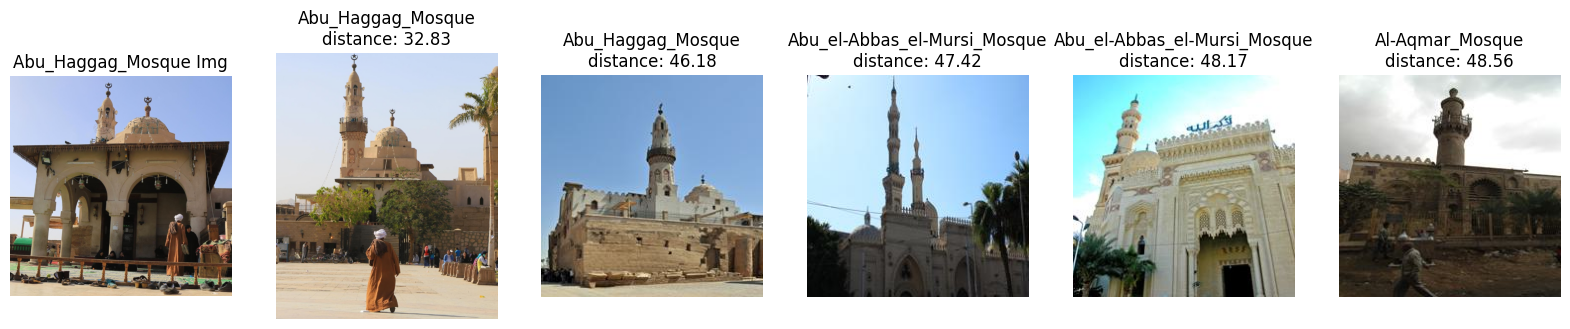

Case  Accuracy  Avg_similarity  search_time
0  Case1       0.4       44.632167     3.145625

In [47]:
avg_similarity, search_time, accuracy = query(test_image_path, collection_name_unmasked, n_results=5, true_label=true_label)
results_df = add_experiment_result(results_df, 'Case1', accuracy, avg_similarity, search_time)
results_df

### case 2. 마스킹하지 않은 벡터DB 내에서 `마스킹한 이미지 검색'
- case1과 동일한 `unmasked_travel` 벡터DB를 사용하므로 필요한 코드만 입력

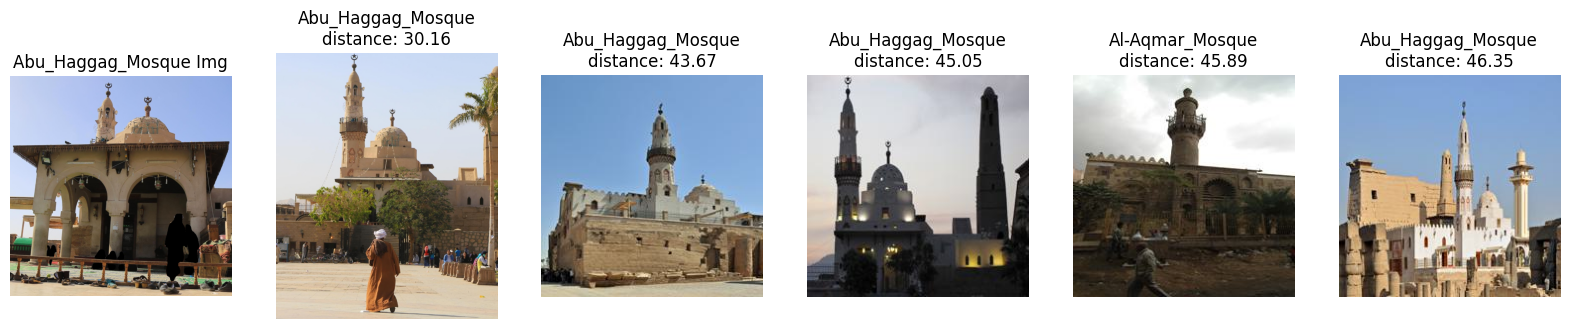

Case  Accuracy  Avg_similarity  search_time
0  Case1       0.4       44.632167     3.145625
1  Case2       0.8       42.225236     5.034295

In [48]:
# query 함수를 호출하여 유사도 및 검색 시간 측정, 이때 mask_people=True로 설정
avg_similarity, search_time, accuracy = query(test_image_path, collection_name_unmasked, n_results=5, mask_people=True, true_label=true_label)

# 실험 결과를 데이터프레임에 추가
results_df = add_experiment_result(results_df, 'Case2', accuracy, avg_similarity, search_time)
results_df

### case 3. 마스킹한 벡터DB 내에서 `마스킹하지 않은 이미지 검색'

In [49]:
client = chromadb.PersistentClient(path='./data/masked_chroma_db')

In [50]:
collection_name_masked = 'masked_travel'  # 컬렉션 이름 설정

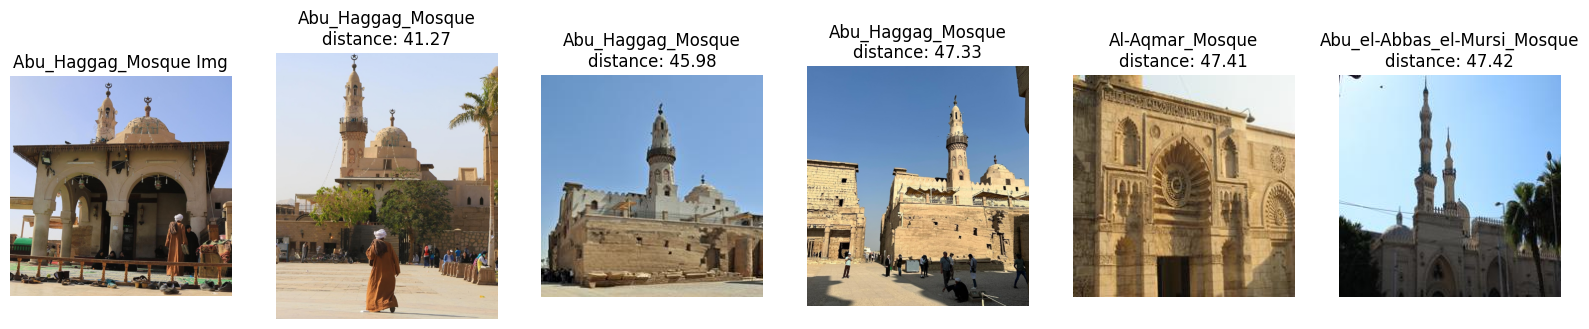

Case  Accuracy  Avg_similarity  search_time
0  Case1       0.4       44.632167     3.145625
1  Case2       0.8       42.225236     5.034295
2  Case3       0.6       45.884818     2.022622

In [51]:
avg_similarity, search_time, accuracy = query(test_image_path, collection_name_masked, n_results=5, true_label=true_label)
results_df = add_experiment_result(results_df, 'Case3', accuracy, avg_similarity, search_time)
results_df

### case 4. 마스킹한 벡터DB 내에서 `마스킹한 이미지 검색'

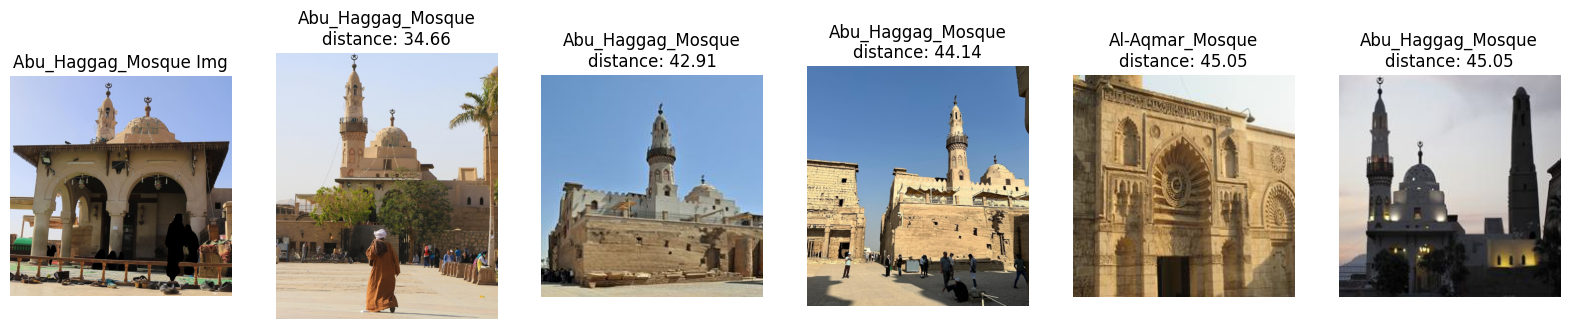

Case  Accuracy  Avg_similarity  search_time
0  Case1       0.4       44.632167     3.145625
1  Case2       0.8       42.225236     5.034295
2  Case3       0.6       45.884818     2.022622
3  Case4       0.8       42.362720     4.419754

In [52]:
avg_similarity, search_time, accuracy = query(test_image_path, collection_name_masked, n_results=5, mask_people=True, true_label=true_label)
results_df = add_experiment_result(results_df, 'Case4', accuracy, avg_similarity, search_time)
results_df

# 결론

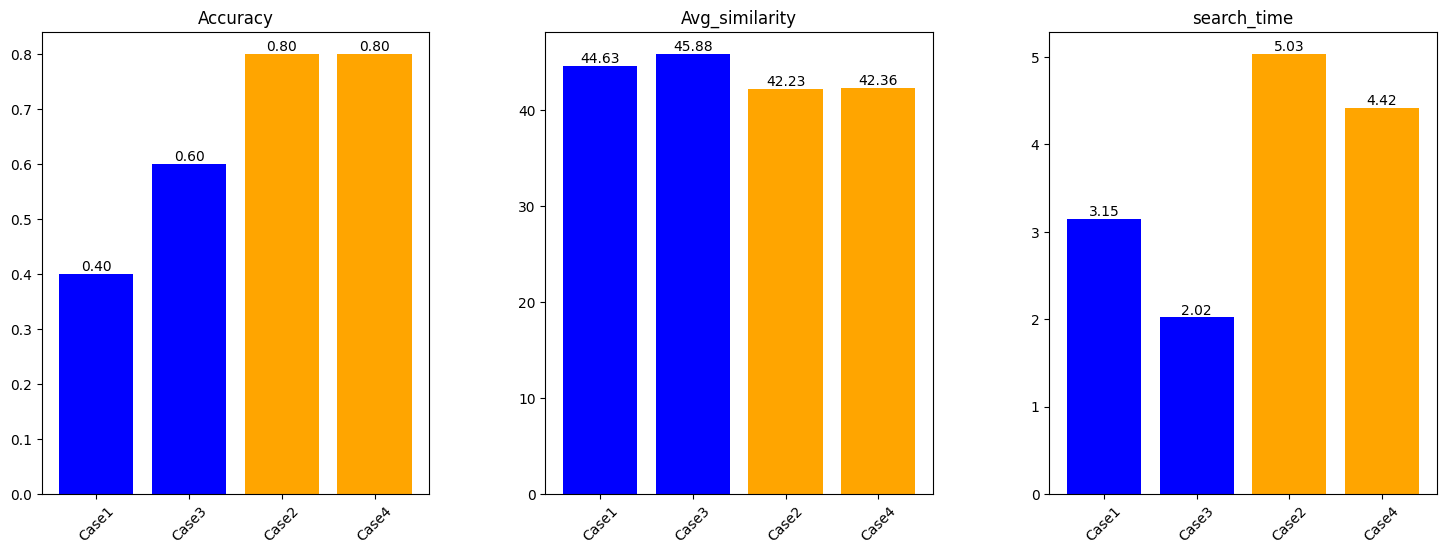

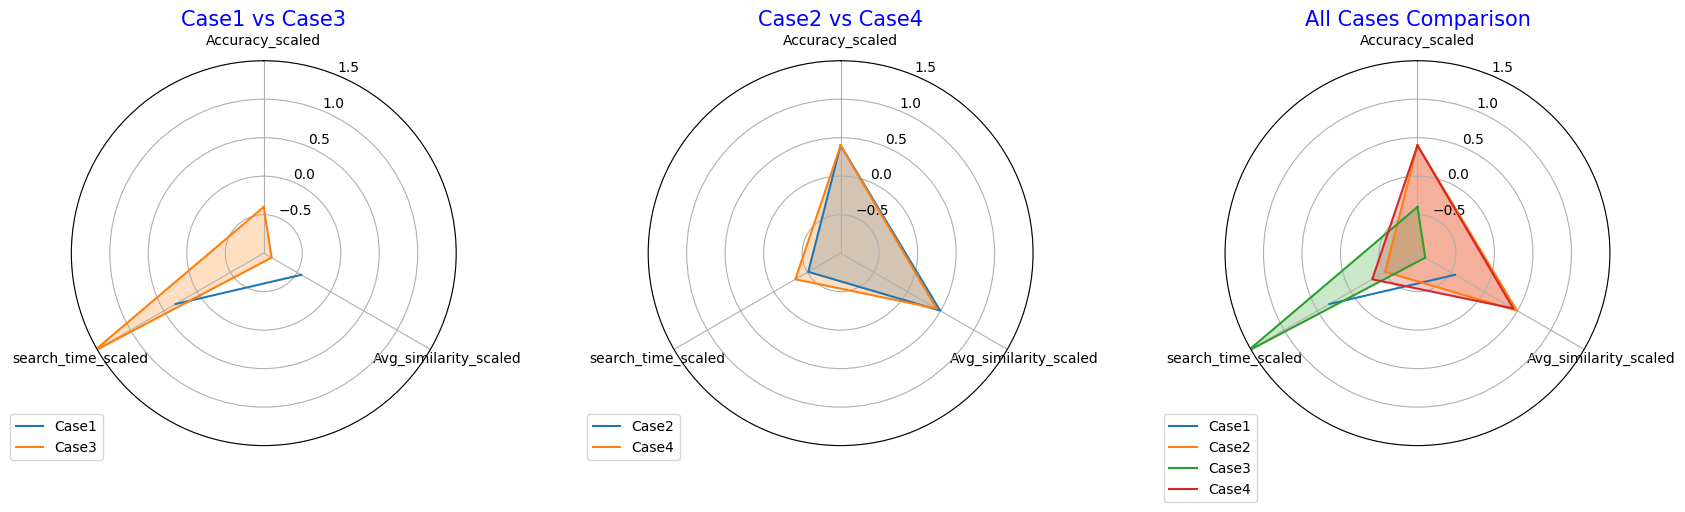

In [80]:
"""
Bar chart 
"""
# 케이스별 그룹 위치 설정
group_positions = {'Case1': 0, 'Case3': 1, 'Case2': 2, 'Case4': 3}

# 지표별로 별도의 그래프를 그리기 위한 subplot 설정
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 각 지표별로 막대그래프 그리기
for i, metric in enumerate(['Accuracy', 'Avg_similarity', 'search_time']):
    values = []
    for case in results_df['Case']:
        value = results_df.loc[results_df['Case'] == case, metric].values[0]
        pos = group_positions[case]
        bar = axs[i].bar(pos, value, color='blue' if '1' in case or '3' in case else 'orange')
        values.append((pos, value))
        # 각 막대 위에 수치 표시
        axs[i].text(pos, value, f'{value:.2f}', ha='center', va='bottom')

        axs[i].set_title(metric)
        axs[i].set_xticks(range(len(group_positions)))
        axs[i].set_xticklabels(group_positions.keys(), rotation=45)
        
# 서브플롯 간 간격 조정
plt.subplots_adjust(wspace=0.3)

# 그래프 표시
plt.show()

"""
Star Chart
"""

from sklearn.preprocessing import RobustScaler

# 데이터 프레임 복사
star_df = results_df.copy()

# 'Avg_similarity'와 'search_time'의 역수를 취함
star_df['Avg_similarity'] = 1 / star_df['Avg_similarity']
star_df['search_time'] = 1 / star_df['search_time']

# RobustScaler로 표준화 진행
scaler = RobustScaler()
scaled_features = scaler.fit_transform(star_df[['Accuracy', 'Avg_similarity', 'search_time']])

# 조정된 값을 데이터프레임에 추가
df_scaled = pd.DataFrame(scaled_features, columns=['Accuracy_scaled', 'Avg_similarity_scaled', 'search_time_scaled'])

# 조정된 값과 케이스 이름을 결합
df_final = pd.concat([star_df['Case'], df_scaled], axis=1)

# Star chart 그리기 준비
labels = df_final.columns[1:]
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# 스타 차트를 1행 3열로 그리기 준비
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=3, subplot_kw=dict(polar=True))

# 각 서브플롯에 대해 y축 범위 설정
for ax in axs:
    ax.set_ylim(-1.0, 1.5)

# Case1과 Case3을 첫 번째 캔버스에 겹쳐서 그리기
for case in ['Case1', 'Case3']:
    i = df_final[df_final['Case'] == case].index[0]
    data = df_final.drop('Case', axis=1).iloc[i].tolist()
    data += data[:1]
    axs[0].plot(angles, data, label=case)
    axs[0].fill(angles, data, alpha=0.25)

axs[0].set_title('Case1 vs Case3', size=15, color='blue', position=(0.5, 1.1))
axs[0].set_theta_offset(np.pi / 2)
axs[0].set_theta_direction(-1)
axs[0].set_thetagrids(np.degrees(angles[:-1]), labels)
axs[0].legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Case2와 Case4를 두 번째 캔버스에 겹쳐서 그리기
for case in ['Case2', 'Case4']:
    i = df_final[df_final['Case'] == case].index[0]
    data = df_final.drop('Case', axis=1).iloc[i].tolist()
    data += data[:1]
    axs[1].plot(angles, data, label=case)
    axs[1].fill(angles, data, alpha=0.25)

axs[1].set_title('Case2 vs Case4', size=15, color='blue', position=(0.5, 1.1))
axs[1].set_theta_offset(np.pi / 2)
axs[1].set_theta_direction(-1)
axs[1].set_thetagrids(np.degrees(angles[:-1]), labels)
axs[1].legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# 모든 케이스를 세 번째 캔버스에 겹쳐서 그리기
for case in ['Case1', 'Case2', 'Case3', 'Case4']:
    i = df_final[df_final['Case'] == case].index[0]
    data = df_final.drop('Case', axis=1).iloc[i].tolist()
    data += data[:1]
    axs[2].plot(angles, data, label=case)
    axs[2].fill(angles, data, alpha=0.25)

axs[2].set_title('All Cases Comparison', size=15, color='blue', position=(0.5, 1.1))
axs[2].set_theta_offset(np.pi / 2)
axs[2].set_theta_direction(-1)
axs[2].set_thetagrids(np.degrees(angles[:-1]), labels)
axs[2].legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout(pad=5)
plt.show()

### 성능 비교 분석

- 실험 결과와 제공된 케이스들을 바탕으로, 각 방법의 적합성을 평가하는 것은 다음과 같은 요소를 고려해야 합니다.
    - **정확도의 중요성**: 얼마나 정확하게 유사 이미지를 찾는 것이 중요한가?
    - **검색 속도의 중요성**: 사용자 경험에 있어 응답 시간이 얼마나 큰 영향을 미치는가?
    - **시스템의 활용 환경**: 시스템이 운영될 환경과 이 환경에서 요구되는 성능 기준은 무엇인가?


- 위 기준으로 결과를 평가해 보자면 `기억의 지도` 에서 유사이미지 찾기를 활용한 '관광지 찾기' 는 기본적으로 **'정확도'** 를 우선적으로 해야 합니다.
- 물론 AWS상에서 FastAPI로 데이터를 처리하고 리턴하는것을 고려하면 처리 속도에서도 어느정도 성능은 확보해야 합니다.
- 즉, 어느정도의 Trade off는 감수해야 하지만 기본적으로 정확도를 더 우선시 해야 합니다.

---

- 결론적으로 높은 정확도(0.8)이면서 상대적으로 빠른 검색속도(4.42)를 보이는 **Case4 (마스킹한 DB에서 마스킹한 이미지를 검색하는것) 이 가장 적절함**을 알 수 있습니다.